# Stay-travel cluster classification in 1D: homebrew

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller

In [26]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [2]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

## Make the artificial data: 1D1T

**note** "T" here means just the index; later, it could be considered "time"

## Regularize the data

Standardize features by removing the mean and scaling to unit variance

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

## DBScan

### Parameters

The basic algorithmic usage
```
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
```

* `eps` : `float`, default=0.5
    * The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. 
    * This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

* `min_samples` : `int`, default=5
    * The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.


The main returns
```
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
```

# Sythetic data

In [95]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)
stays = [
        get_stay(  0.00,  6.40,-1.00), #home
        get_stay(  6.50, 17.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))


dup_mask = get_mask_with_duplicates(time, 0.005, 0.6)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.02, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

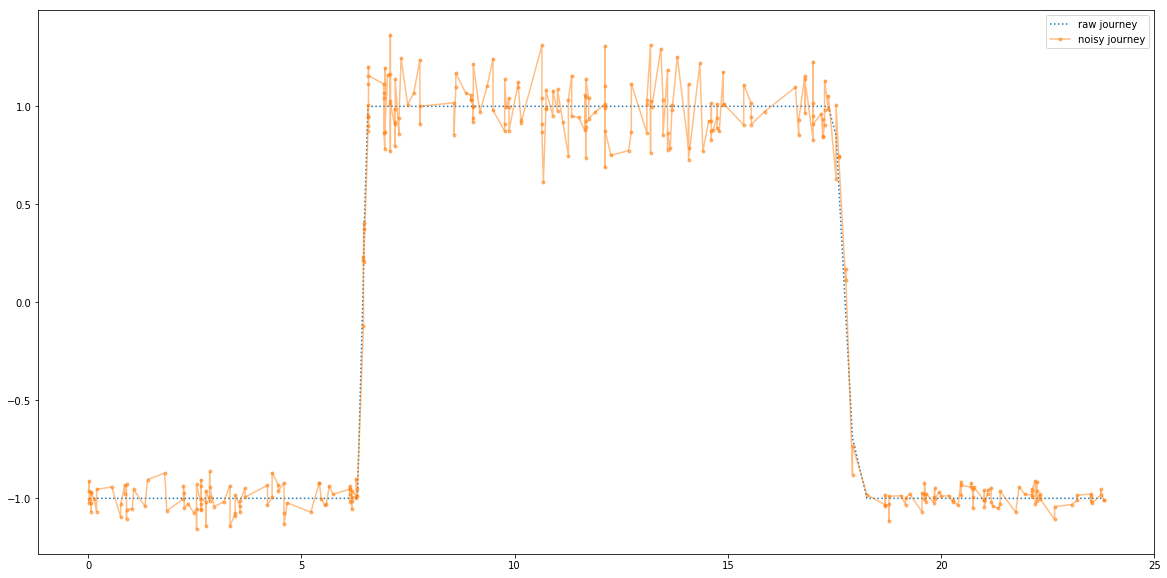

In [96]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend();

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [197]:
time_thresh = 1/12.
eps=0.25

In [98]:
clusters = list(range(noise_journey_sub.size))

In [99]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2) 

In [100]:
def get_clusters(times, positions, dist_thresh, time_thresh):

    # The list of found clusters
    clusters = []

    # index var.
    m = 0
    
    # 
    new_cluster = []
    for n in range(0,positions.size-3):

        # Check temporal connectedness: look for breaks in the time > thresh
        if times[n+1] <= times[n]+time_thresh:

            get_y = positions[n+1]

        else: 
            continue

        # Check spatial connectedness:
        # Get the current cluster mean
        cluster_mean = np.mean(positions[m:n+1])

        # Get the potential cluster mean    
        new_cluster_mean = np.mean(positions[m:n+2])

        err1 = get_err(cluster_mean, get_y)
        err2 = get_err(cluster_mean, new_cluster_mean)

        #print(n, err1, err2, dist_thresh)

        if  (err1 < dist_thresh) & (err2 < dist_thresh) & \
            (n <= positions.size-5):

            new_cluster.append(n)
            #print(len(new_cluster))
        else:
            txt = f'Trying {n} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            #print(txt+app)

            new_cluster = []

            m=n+1
            
    return clusters

In [101]:
clusters = get_clusters(time_sub, noise_journey_sub, eps, time_thresh)
len(clusters)

9

In [102]:
for clust in clusters:
    print(clust)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 19, 21, 23, 25, 26, 27, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 49, 51, 52, 54, 55, 57, 59, 61, 63, 65, 66, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89]
[102, 103, 105, 106]
[118, 119, 120, 121, 123]
[128, 129, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 146, 148, 149, 150, 151, 152, 153, 155, 156, 157, 159, 160, 161]
[164, 165, 167, 169, 172, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184]
[190, 191, 192, 195, 196, 198, 199, 201, 202, 203, 205, 206, 208, 209, 210, 211, 212, 215]
[218, 220, 221, 222, 223, 224, 226, 227, 228, 230, 231, 233, 235, 236, 239, 240, 242, 243, 245]
[248, 250, 251, 252, 253, 254, 255, 257, 259, 260, 261]
[268, 269, 271, 272, 275, 278, 279, 280, 281, 282, 283, 285, 286, 287, 289, 292, 294, 295, 296, 298, 299, 300, 301, 302, 304, 305, 306, 307, 308, 310, 311, 313, 314, 316, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 331, 334, 336, 337, 338]


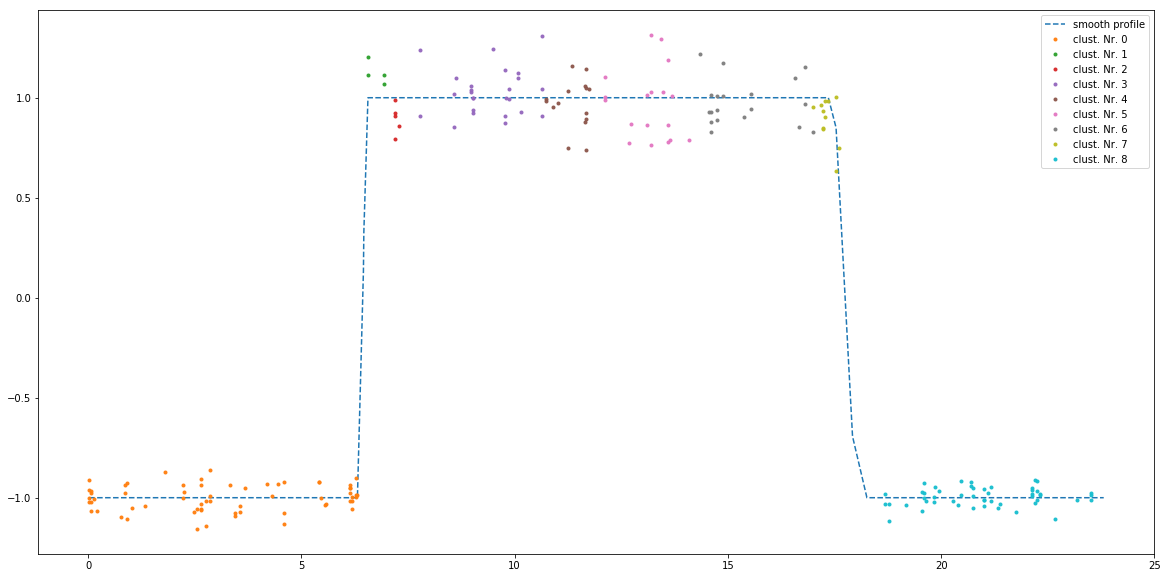

In [103]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')

for cl_nr, clust in enumerate(clusters):
    plt.plot(time_sub[clust], noise_journey_sub[clust], '.', alpha=0.95, label=f'clust. Nr. {cl_nr}')

plt.legend();

```
# Calculate first and third quartile
# the the quantiled std
q25 = np.quantile(time_sub[m:nn],0.25, interpolation='lower')
q75 = np.quantile(time_sub[m:nn],0.75, interpolation='higher')

# Interquartile range
iqr = q75 - q25

# Remove outliers
q75_ind = np.max(np.where(time_sub[m:nn] < (q75 + 3 * iqr)))
q25_ind = np.min(np.where(time_sub[m:nn] > (q25 - 3 * iqr)))
```

In [104]:
m=0
nn=117
q25 = np.quantile(noise_journey_sub[m:nn],0.25, interpolation='lower')
q75 = np.quantile(noise_journey_sub[m:nn],0.75, interpolation='higher')

print(np.quantile(noise_journey_sub[m:nn],[0.25, 0.5, 0.75], interpolation='higher'))
#print()

#print(np.sort(noise_journey_sub[m:nn]))
# Interquartile range

iqr = abs(q75 - q25)
iqr_fact = 3

print()
print(q25, q75, iqr,(q25 - iqr_fact * iqr), (q75 + iqr_fact * iqr))
iqr_fact = 0
print(m, nn, np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr))))
mask=np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr)))
print(noise_journey_sub[m:nn].size, np.std(noise_journey_sub[m:nn]),noise_journey_sub[mask].size, np.std(noise_journey_sub[mask]))

[-1.03004071 -0.96578867 -0.89950575]

-1.0300407136896945 -0.8995057485488529 0.13053496514084162 -1.4216456091122194 -0.507900853126328
0 117 (array([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 14, 15, 16, 20, 22, 25, 26,
       27, 29, 33, 36, 37, 39, 40, 42, 43, 45, 46, 48, 49, 53, 56, 57, 58,
       59, 61, 63, 64, 65, 68, 70, 71, 72, 75, 76, 77, 78, 79, 80, 81, 82,
       84, 85, 86, 87, 89, 90]),)
117 0.7871933198432219 57 0.03494980994034673


In [252]:
def get_iqr_masked(positions, iqr_fact = 3):
    # Calculate first and third quartiles
    q25 = np.quantile(positions,0.25, interpolation='lower')
    q75 = np.quantile(positions,0.75, interpolation='higher')

    # Calculate the interquartile range (IQR)
    iqr = abs(q75 - q25)

    #print(m, nn, np.where((noise_journey_sub[m:nn] > (q25 - iqr_fact * iqr)) & (noise_journey_sub[m:nn] < (q75 + iqr_fact * iqr))))
    mask=np.where(  (positions > (q25 - iqr_fact * iqr)) \
                  & (positions < (q75 + iqr_fact * iqr)))    
    
    return mask

def get_iqr_std(positions, iqr_fact = 3):
    
    if len(positions) > 1:

        mask=get_iqr_masked(positions, iqr_fact)
    
        return np.std(positions[mask])
    else:
        return positions[0]

def get_iqr_avg(positions, iqr_fact = 3):
    
    if len(positions) > 1:

        mask=get_iqr_masked(positions, iqr_fact)
    
        return np.mean(positions[mask])
    else:
        return positions[0]

In [106]:
def get_batch_clusters(times, positions, dist_thresh, time_thresh):

    # Get the max length of any cluster
    max_len = positions.size-6
    
    # The list of found clusters
    clusters = []

    # global indexing var
    ind = 0
    
    # Current cluster: a list of indices
    cluster = [0]
    
    # the last time point of a given cluster
    last_time_point = times[cluster[0]]

    # local indexing var
    m = 0 
    
    # iterate through the elements
    while ind < max_len:

        
        # Set the time buffer around the last point of the current cluster
        # look for the next temporally connected event
        # NOTE: _all_ events can be connected if the samp. freq. is high enough!
        # TODO: try something else!!!
        nn=m+1
        while (times[nn]-last_time_point <= time_thresh) & (nn<=max_len):
            nn+=1

        #print(m,nn, positions[m:nn].shape)
        
        if positions[m:nn].size > 1:
            
            # Get the current cluster std
            cluster_std = np.std(positions[m:nn])
            cluster_qstd = get_iqr_std(positions[m:nn])
            
        else:
            cluster_std = 0.0
            cluster_qstd = 0.0
        
        nnn=nn
        while ((positions[m:nnn].size > 1) & ((cluster_std >= dist_thresh) | (cluster_qstd >= dist_thresh))):
            print('\t\trefinement', nnn, cluster_std, cluster_qstd)
            # Get the current cluster std
            cluster_std = np.std(positions[m:nnn])
            cluster_qstd = get_iqr_std(positions[m:nnn])
            nnn-=1

        # Check!
        print('STD-testing at', nn, cluster_std, cluster_qstd, dist_thresh)
        # 
        new_cluster = list(range(m,nnn+1))

        # if the std's are good, keep the cluster, and update the final time point
        if  (cluster_std < dist_thresh) & (cluster_qstd < dist_thresh) & (nnn<max_len) & (nnn==nn) :

            last_time_point = times[nnn]
            ind = nnn

        else:
            txt = f'Trying {len(new_cluster)} '
            app = "Nope"
            if (len(new_cluster) >= 2):
                if (times[new_cluster[-1]]-times[new_cluster[0]] > time_thresh):
                    clusters.append(new_cluster)
                    app = 'closed'
            print(txt+app)

            new_cluster = []
            if (nnn==nn):
                ind=nn
                m=nn
            else:
                ind=nnn
                m=nnn
            
    return clusters

In [107]:
clusters = get_batch_clusters(time_sub,noise_journey_sub,eps,time_thresh)
len(clusters)

STD-testing at 8 0.04431320835368829 0.04431320835368829 0.25
STD-testing at 11 0.04552891067606445 0.04552891067606445 0.25
STD-testing at 12 0.04613510547079622 0.04613510547079622 0.25
STD-testing at 14 0.05111635574431443 0.05111635574431443 0.25
STD-testing at 19 0.05679584695744077 0.05679584695744077 0.25
STD-testing at 21 0.056110611872019114 0.056110611872019114 0.25
STD-testing at 23 0.057867357650645136 0.057867357650645136 0.25
STD-testing at 25 0.062381175995577506 0.062381175995577506 0.25
STD-testing at 29 0.05990970218706435 0.05990970218706435 0.25
STD-testing at 30 0.059204381666914545 0.059204381666914545 0.25
STD-testing at 34 0.06486893436563486 0.06486893436563486 0.25
STD-testing at 40 0.06390400391012144 0.06390400391012144 0.25
STD-testing at 43 0.06542339717351264 0.06542339717351264 0.25
STD-testing at 47 0.06650858707435166 0.06650858707435166 0.25
STD-testing at 48 0.06607091838574927 0.06607091838574927 0.25
STD-testing at 49 0.06543688621011376 0.06543688

4

In [108]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [109]:
shuffle(colors)

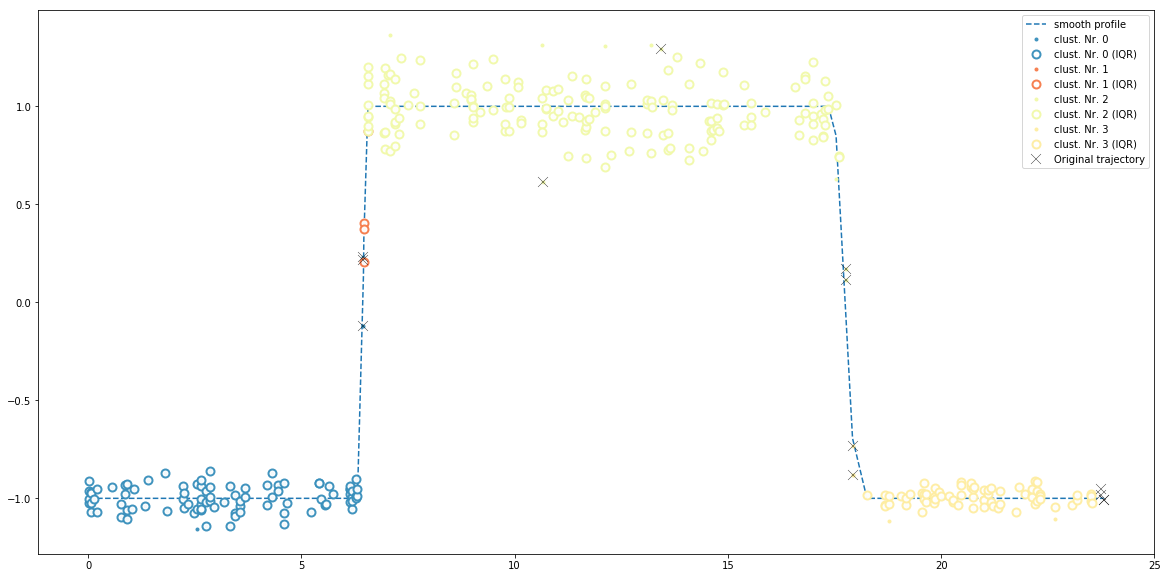

In [110]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')


iqr_points_kwargs={'marker':'o', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':8.0, 'alpha':0.95, 
                   'label':'label'}

all_points_kwargs={'marker':'.', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':4.0, 'alpha':0.95, 
                   'label':'label'}

    
def get_new_kwargs(kwargs_dct):
    
    def meth(color, label):
        kwargs_dct.update({'color':color,'label':label})
        return kwargs_dct
    return meth
        
pdf = pd.DataFrame()
pdf_all = pd.DataFrame({'x':time_sub,'y':noise_journey_sub})

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr]   
    
    xs = time_sub[clust]
    ys = noise_journey_sub[clust]
    
    label=f'clust. Nr. {cl_nr}'
    plt.plot(xs, ys, **get_new_kwargs(all_points_kwargs)(color,label))
    
    label=f'clust. Nr. {cl_nr} (IQR)'
    mask=get_iqr_masked(ys,1)
    plt.plot(xs[mask], ys[mask], **get_new_kwargs(iqr_points_kwargs)(color,label))

    pdf1  = pd.DataFrame({'x':xs[mask],'yy':ys[mask]})
    #pdf2  = pd.DataFrame({'x':rxs[rmask],'y':rys[rmask]})
    #pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    pdf = pd.concat([pdf,pdf1])

# plot the rest of the samples
pdf_all = pdf_all.merge(pdf, on=['x'], how='outer')
pdf_all['keep'] = pdf_all.yy.apply(np.isnan)
pdf_sub = pdf_all[pdf_all['keep']]
plt.plot(pdf_sub.x.values, pdf_sub.y.values, alpha=0.95, linestyle='',color='k', marker='x', markersize=10.0, markeredgewidth=0.40, linewidth=0.50, label='Original trajectory')

plt.legend();

In [111]:
clusters_rev = get_batch_clusters(np.max(time_sub)-time_sub[::-1],noise_journey_sub[::-1], eps,time_thresh)
len(clusters_rev)

STD-testing at 4 0.02242064219609894 0.02242064219609894 0.25
STD-testing at 8 0.021281041664675388 0.021281041664675388 0.25
STD-testing at 10 0.019927644375936606 0.019927644375936606 0.25
STD-testing at 11 0.02171778959505699 0.02171778959505699 0.25
STD-testing at 13 0.03635242594544453 0.03635242594544453 0.25
STD-testing at 19 0.03788912520416421 0.03788912520416421 0.25
STD-testing at 25 0.03938129037655559 0.03938129037655559 0.25
STD-testing at 26 0.038704083562804414 0.038704083562804414 0.25
STD-testing at 28 0.041304829760071445 0.041304829760071445 0.25
STD-testing at 31 0.041431958774891565 0.041431958774891565 0.25
STD-testing at 34 0.041339829469188585 0.041339829469188585 0.25
STD-testing at 40 0.039943333205818866 0.039943333205818866 0.25
STD-testing at 46 0.04130665972736344 0.04130665972736344 0.25
STD-testing at 50 0.04232540705293511 0.04232540705293511 0.25
STD-testing at 52 0.04175035234452086 0.04175035234452086 0.25
STD-testing at 53 0.0413607809710912 0.0413

4

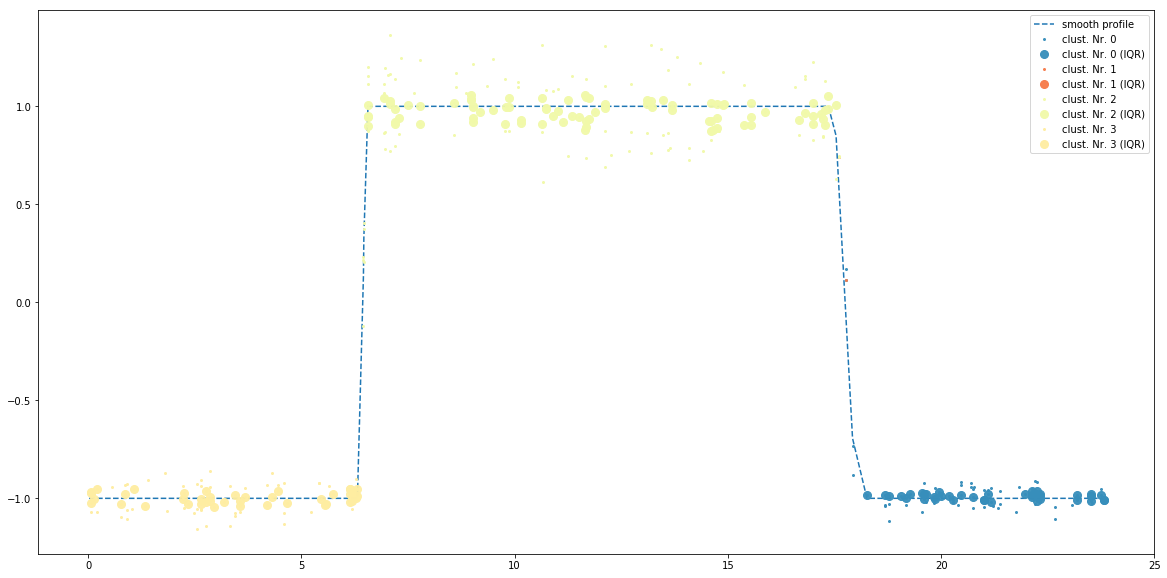

In [112]:
plt.figure(figsize=(20,10))

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')

for cl_nr, clust in enumerate(clusters_rev):
    
    xs = time_sub[::-1][clust]
    ys = noise_journey_sub[::-1][clust]
    
    plt.plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    iqr_fact = 0
    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    plt.plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    
plt.legend();

6.315277777777778 0.0675
0.0675 6.315277777777778
17.59861111111111 6.315277777777778
6.315277777777778 17.59861111111111
17.76 17.59861111111111
17.59861111111111 17.76
23.81222222222222 17.76
17.76 23.81222222222222


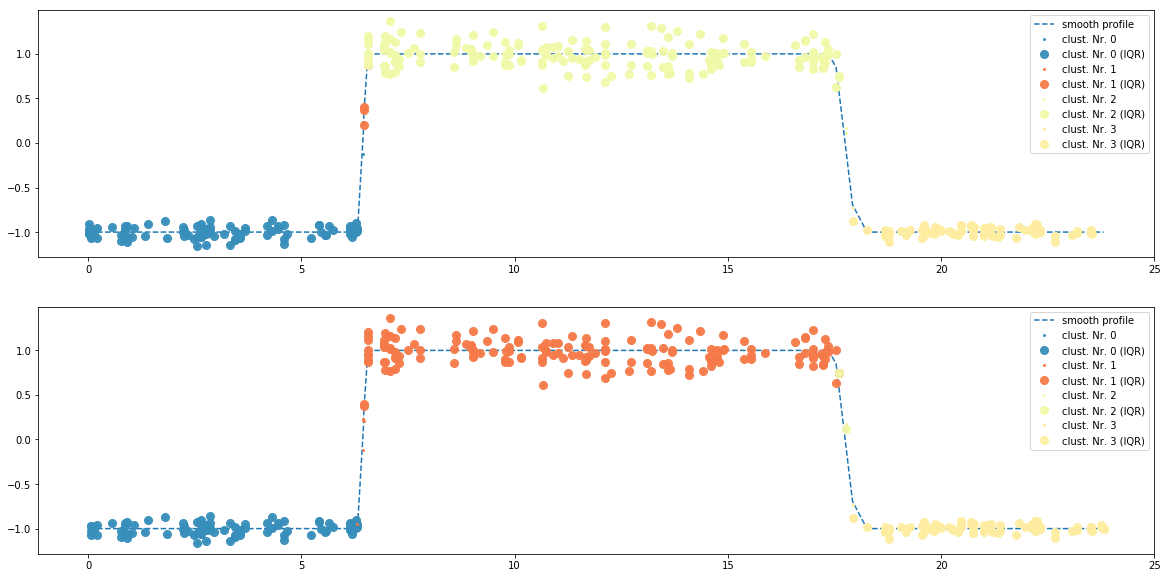

In [113]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax = ax.reshape(2,)

ax[0].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[1].plot(time_sub, raw_journey_sub, '--', label='smooth profile')


for cl_nr, clust in enumerate(clusters):
    
    xs = time_sub[clust]
    ys = noise_journey_sub[clust]
    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    ax[0].plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
for cl_nr, clust in enumerate(clusters_rev[::-1]):

    xs = time_sub[::-1][clust]
    ys = noise_journey_sub[::-1][clust]
    
    print(xs[0],xs[-1])    
    xs = xs[::-1]
    print(xs[0],xs[-1])
    
    ys = ys[::-1]
    ax[1].plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    ax[1].plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();

## Notes
* need to ensure the time-backward trajectory works in roughly the same way as the time-forward one
* need to have something that merges nearby clusters if they are close enough in time and space

0.026666666666666665 6.466111111111111
0.026666666666666665 6.466111111111111
6.466111111111111 6.5625
6.466111111111111 6.5625
6.5625 17.923055555555557
6.5625 17.923055555555557
17.923055555555557 23.53361111111111
17.923055555555557 23.53361111111111


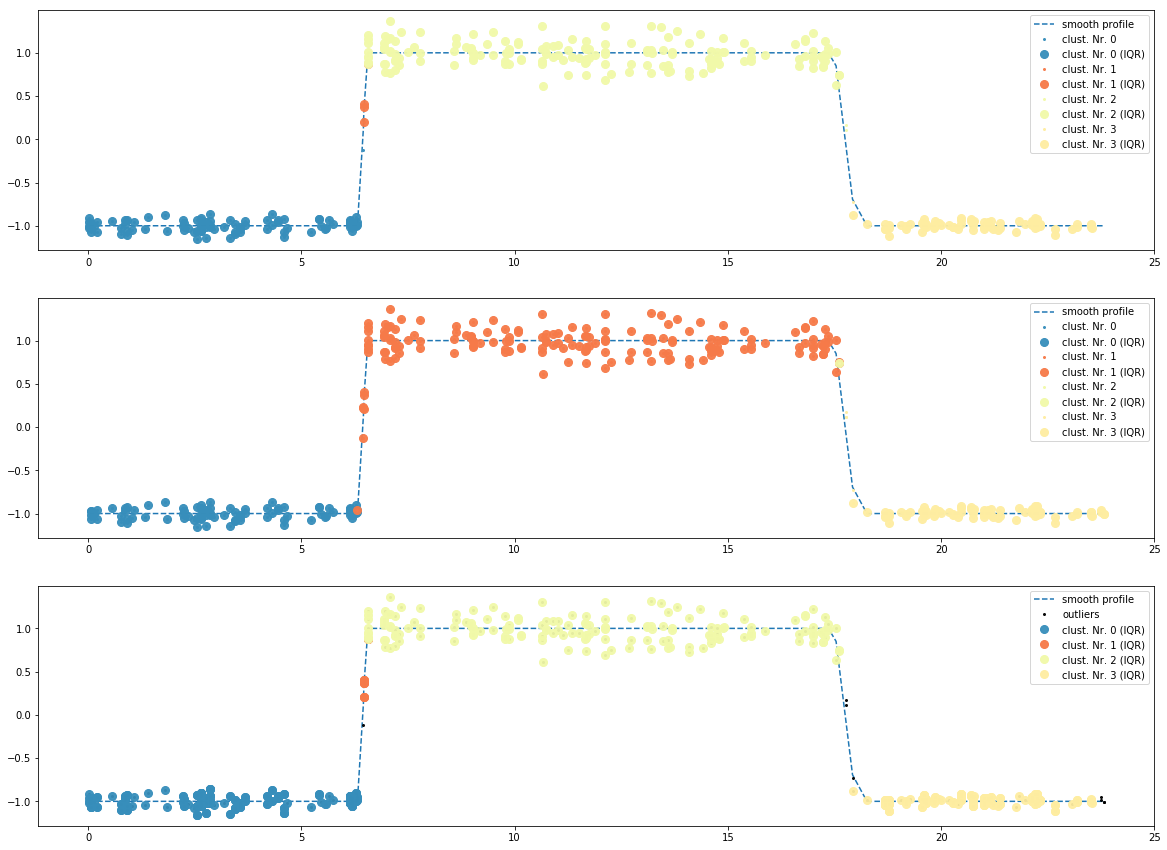

In [114]:
fig, ax = plt.subplots(3,1, figsize=(20,15))
ax = ax.reshape(3,)

ax[0].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[1].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[2].plot(time_sub, raw_journey_sub, '--', label='smooth profile')
ax[2].plot(time_sub, noise_journey_sub, '.', alpha=0.95, color='k', markersize=4.0, label='outliers')    


get_match = lambda x,y: (np.isnan(x) | np.isnan(x))
get_val = lambda x,y: x if np.isnan(x)==False else y

cl_nr = 0

for clust, rclust in zip(clusters,clusters_rev[::-1]):
    
    xs = time_sub[clust]
    ys = noise_journey_sub[clust]
    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    ax[0].plot(xs[mask], ys[mask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
    pdf1  = pd.DataFrame({'x':xs[mask],'y':ys[mask]})

    
    rxs = time_sub[::-1][rclust]
    rys = noise_journey_sub[::-1][rclust]
    
    print(xs[0],xs[-1])    
    rxs = rxs[::-1]
    print(xs[0],xs[-1])
    
    rys = rys[::-1]
    ax[1].plot(rxs, rys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    rmask=np.where((rys > (q25 - iqr_fact * iqr)) & (rys < (q75 + iqr_fact * iqr)))
    
    ax[1].plot(rxs[rmask], rys[rmask], 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();
    
    pdf2  = pd.DataFrame({'x':rxs[rmask],'ry':rys[rmask]})    
    
    pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    #pdf = pd.concat([pdf,pdf1.merge(pdf2, on=['x'], how='outer')])
    
    pdf['matched'] = pdf.apply(lambda x: get_match(x['y'],x['ry']), axis=1)
    pdf['yy'] = pdf.apply(lambda x: get_val(x['y'],x['ry']), axis=1)

    
    ax[2].plot(pdf[pdf['matched']==False].x.values, pdf[pdf['matched']==False].y.values, 'o', color=colors[cl_nr], markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    #ax[2].plot(pdf[pdf['matched']].x.values, pdf[pdf['matched']].yy.values, '.', alpha=0.95, color='k', markersize=4.0, label=None)


    ax[2].legend();    
    
    cl_nr += 1